In [35]:

# !pip install ipykernel

import os 

os.chdir('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main')
# from dataloaders.datasets.nyud_geonet import NYUD_GeoNet

from dataloaders.datasets.iiw_dataset import IIWDataset
import matplotlib.pyplot as plt
import numpy as np 
import cv2
import scipy.io as scio
from eval_tools.iiw_evaluator import IIWEvaluator

from os.path import join, split, exists, isdir, isfile
from utils import * 

import torchvision.transforms as transforms 
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

from skimage import img_as_ubyte

In [88]:


import torch
    
    

def draw_point(img,point,point_color=(255,0,0),point_size = 1,thickness = 4):
    # thickness = 4 # 可以为 0 、4、8
    cv2.circle(img,point, point_size, point_color, thickness)

def gen_color():
    return (np.random.random((1,3))*255).astype(np.int32)[0].tolist() # BGR

def draw_point_pair(img,p1,p2):
    img = check_img(img)
    point_color = gen_color()
    draw_point(img,p1,point_color)
    draw_point(img,p2,point_color)
    draw_arraw(img,p1,p2,color=point_color,thickness=2,tipLength=0.09)


    return img
    


def draw_arraw(src,p1,p2,color=(0,0,255),thickness=2,line_type=0,shift=0,tipLength=0.1):
    """
    # int thickness #线宽
    # int line_type #线的类型
    # int shift #箭头位置平移系数
    # double tipLength  #箭头大小缩放系数
    """
    # Mask = 255*np.ones((100,100,3), dtype=np.int)
    # Mask = np.array(Mask, dtype='uint8')
    cv2.arrowedLine(src,p1, p2, color,thickness,line_type,shift,tipLength)


def draw_label(img,points,labels):
    if img.max()<=1:
        img = np.array(img*255,dtype=np.uint8)

    img = check_img(img)
    image_shape=torch.from_numpy(np.array(img.shape[:-1]))

    for idx,(points,label) in enumerate(zip(points,labels)):#* value range is between 0 and 1 

        # print(labels[idx])
        if label[0]!='E':
            p1= (points[0]*image_shape).int().numpy()
            p2= (points[1]*image_shape).int().numpy()
            img = draw_point_pair(img,p1,p2)
            
            
    return img




def draw_activated_points(image,edge_map,points,labels,shape=(512,512)):
    
    
    def inside_square(axis_x,axis_y,pred_edge_xy):
            #* filter the square
        min_border = np.where(pred_edge_xy[:,0] >= axis_x.min(),1,0)
        max_border = np.where(pred_edge_xy[:,0] <= axis_x.max(),1,0)
        pred_edge_xy = pred_edge_xy[min_border == max_border]

        min_border = np.where(pred_edge_xy[:,1] >= axis_y.min(),1,0)
        max_border = np.where(pred_edge_xy[:,1] <= axis_y.max(),1,0)
        pred_edge_xy = pred_edge_xy[min_border == max_border]
        return pred_edge_xy

    def in_same_line(p1,p2,xy,error_threshold = 1):
        
        vector1=p1-xy 
        vector2=p2-xy 
        # if vector1[0]/(vector1[1]+1e-5)  - vector2[0]/(vector2[1]+1e-5) < 1e-4:
        #     pass
        # print(abs(vector1[0]*vector2[1] -vector2[0]*vector1[1] ) / ((p1-p2)**2).sum()**(0.5))
        if abs(vector1[0]*vector2[1] -vector2[0]*vector1[1] ) / ((p1-p2)**2).sum()**(0.5)  < error_threshold: #* 1e+1, 4e+1 and 5e+1  the bound inside the line,  
        # if : #* 1e+1, 4e+1 and 5e+1  the bound inside the line,  
            return True

        return False
    
    #!=============================
    #? why 
    edge_map = np.concatenate([edge_map[:,1][:,None],edge_map[:,0][:,None]],axis=1)
    #!=============================
    for idx,(point,label)  in enumerate(zip(points,labels)):
        if label[0] != 'E':
            p1 = (point[0]*shape).int()
            p2 = (point[1]*shape).int()

            p12=torch.cat([p1[None,...],p2[None,...]],axis=0).numpy()
            axis_x = p12[:,0]
            axis_y = p12[:,1]

            pred_edge_xy= inside_square(axis_x,axis_y,edge_map.copy())
            
            #* debug
            image = draw_point_pair(image,p1.numpy(),p2.numpy())
            
            for idx in pred_edge_xy:
                xy = torch.from_numpy(idx).int()
                if  in_same_line(p1,p2,xy,1):
                    #* debug
                    # print('xy:',x,y,'\t p1:',p1,'\t p2:',p2)
                    # draw_point(image,xy.numpy(),point_color=gen_color(),point_size=1)
                    # draw_point(image,xy.numpy(),point_color=gen_color(),point_size=3)
                    draw_point(image,xy.numpy(),point_color=gen_color(),point_size=5)
                    break
                    
                    

    #* debug
    # cv2.imwrite(self.gen_name()+'.jpg',self.tmp_img)
    return image



class Checker:


    def __init__(self,root,iiw_dataset = None):

        self.dataset = iiw_dataset

        self.to_imger =transforms.ToPILImage()
        self.root  = root
        
        self.pre_path = join(root,'reflectance','met')
        self.predictions = sorted(os.listdir(self.pre_path))


    def __len__(self):
        
        return len(self.predictions)
    
    def getitem(self,index):
        
        pred = load_mat(join(self.pre_path , self.predictions[index]))['result']
        name = self.get_name(index)

        image,points, labels = self.dataset.getitem_by_name(name)

        return np.array(self.to_imger(normalize(image))),points, labels,img_as_ubyte(pred),name
    
    def get_name(self,index):
        return self.predictions[index].split('.')[0]
    

    
    


run_iiw = "/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/run_iiw"
# check_model = ['rindnet','hed','rcf']#* rindnet  is worse than hed and rcf ,especially hed
check_model = ['rindnet','hed']#* rindnet  is worse than hed and rcf ,especially hed



dataset = IIWDataset(data_dir='/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/data/IIW/iiw-dataset',split='test')
rindnet_checker = Checker(join(run_iiw,'rindnet'),dataset)
hed_checker = Checker(join(run_iiw,'hed'),dataset)




    

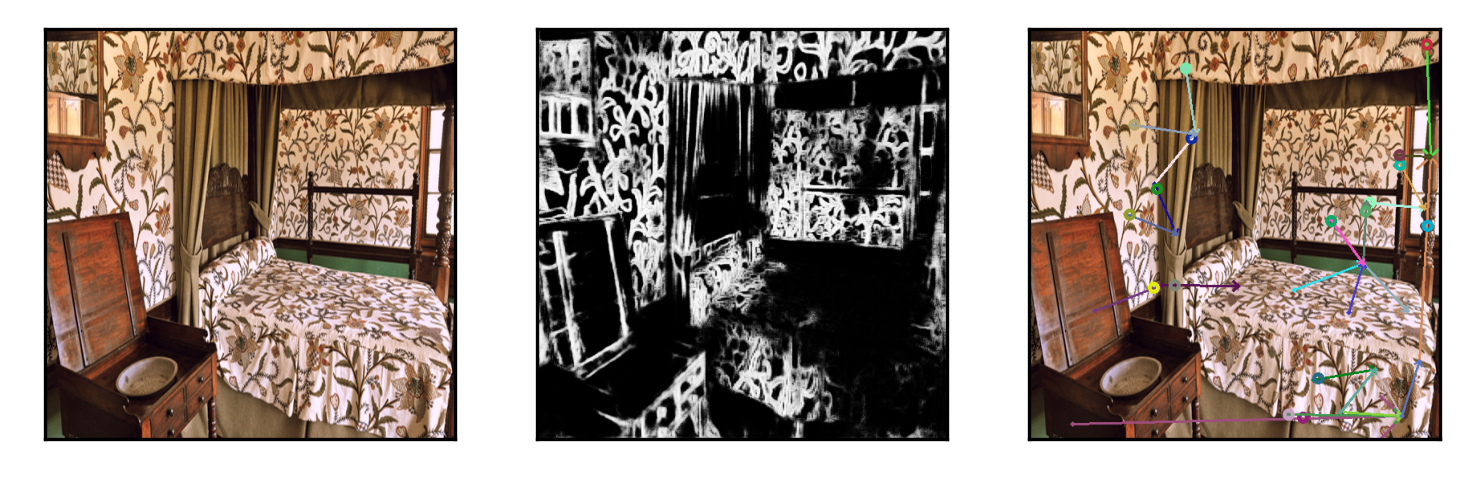

In [89]:

image,points, labels,pred, name = rindnet_checker.getitem(0)
# drawed = draw_label(image,points,labels)
pred_xys = np.argwhere(pred/255 > 0.5)#* trheshold == 0.5
draw_activated_points=draw_activated_points(image,pred_xys,points,labels,np.array(pred.shape))
show_imgs([image,pred,draw_activated_points],[0,1,0])



# image,points, labels,pred, name = hed_checker.getitem(0)
# drawed = draw_label(image,points,labels)
# show_imgs([image,pred,drawed],[0,1,0])

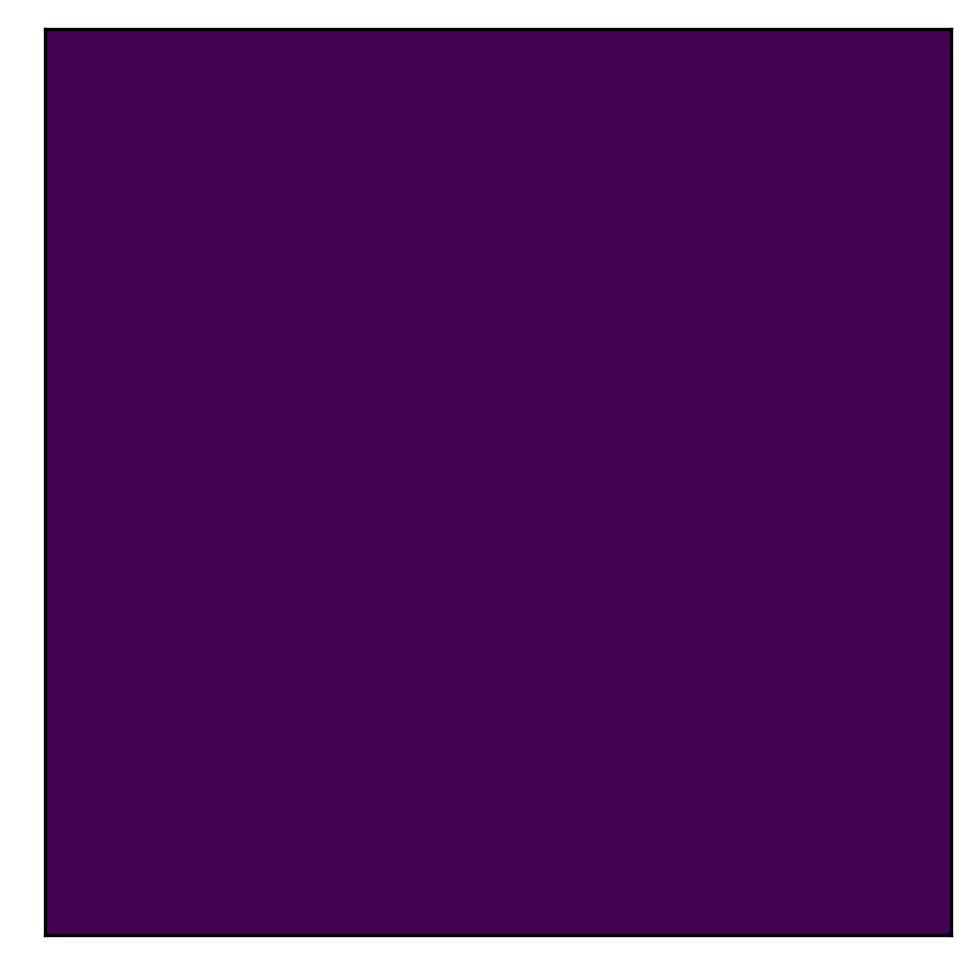

In [78]:
a  = np.zeros(pred.shape)
# a = np.argwhere(pred > 0.5)

show_imgs([a],[0])



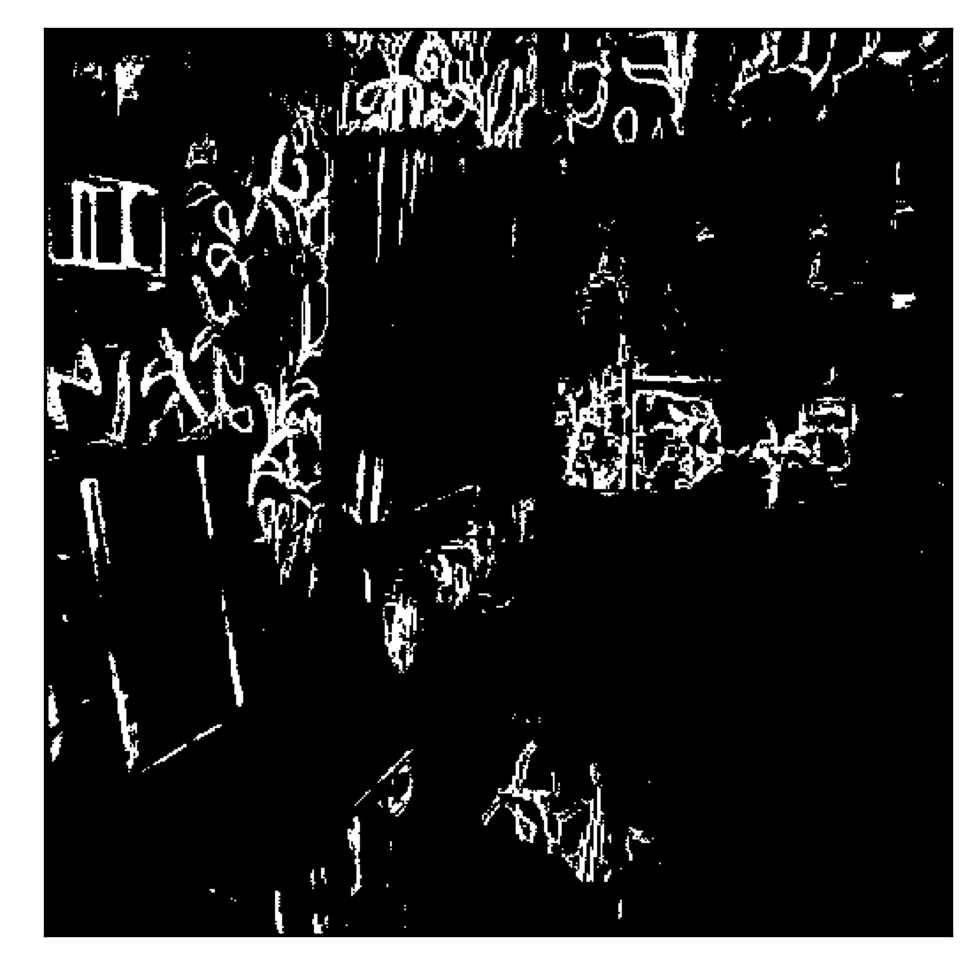

In [83]:
a  = np.zeros(pred.shape)
pred_xys = np.argwhere(pred/255 > 0.9)

for (x,y) in pred_xys:
    a[x,y]  = 255


show_imgs([a],[1])

